In [15]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split, StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from imblearn.over_sampling import SMOTE

In [16]:
# Set random seed
random_seed = 42

In [17]:
df = pd.read_csv('/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv')

In [18]:
# Simple Imputing
imputer = SimpleImputer(missing_values = np.nan,strategy='most_frequent')
imputer.fit(df[['SES']])
df[['SES']] = imputer.fit_transform(df[['SES']])

imputer = SimpleImputer(missing_values = np.nan,strategy='most_frequent')
imputer.fit(df[['CDR']])
df[['CDR']] = imputer.fit_transform(df[['CDR']])

imputer = SimpleImputer(missing_values = np.nan,strategy='most_frequent')
imputer.fit(df[['MMSE']])
df[['MMSE']] = imputer.fit_transform(df[['MMSE']])

imputer = SimpleImputer(missing_values = np.nan,strategy='most_frequent')
imputer.fit(df[['Educ']])
df[['Educ']] = imputer.fit_transform(df[['Educ']])

In [19]:
df.drop(columns=['Delay'],inplace=True)
df['CDR'].value_counts()
df.loc[df['CDR'] == 2,'CDR'] = 1

In [20]:
df.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,OAS1_0004_MR1,M,R,28,2.0,2.0,30.0,0.0,1588,0.803,1.105
4,OAS1_0005_MR1,M,R,18,2.0,2.0,30.0,0.0,1737,0.848,1.010


In [21]:
X_images = []
maxx = -10000
minn = 10000
dataset_name = 'ad-dataset-t88-25p-zoom'

df = df.reset_index()

for idx, row in df.iterrows():
    tag = row['ID']
    filename = f'/kaggle/input/{dataset_name}/dataset_3D/{tag}_T88_111_MASKED_GFC.npz'
    npzfile = np.load(os.path.join(filename))
    temp = npzfile['buffer']
    tmax, tmin = np.max(temp), np.min(temp)
    if tmax > maxx:
        maxx = tmax
    if tmin < minn:
        minn = tmin
    X_images.append(npzfile['buffer'])

In [22]:
print(maxx, minn)
X_images = (X_images - minn)/(maxx - minn)

3983.4158 -515.03125


In [23]:
y = df.pop('CDR')
X_text = np.array(df)
y = [i*2 for i in y]

In [24]:
X_images.shape, X_text.shape

((436, 44, 52, 44, 1), (436, 11))

In [25]:
class Result:
    def __init__(self, tag):
        self.model_tag = tag
        self.test_loss = None
        self.test_accuracy = None
        self.y_pred = None
        self.y_test = None
        self.y_pred_smote = None
        self.y_test_smote = None
        self.model_history = None

In [26]:
results = []

In [27]:
input_layer_text = keras.Input(shape = (9), name='text_input_layer')
x = layers.Dense(16, activation='relu')(input_layer_text)
x1 = layers.Dense(16, activation='relu')(x)
x2 = layers.Dense(16, activation='relu')(x)
x3 = layers.Dense(16, activation='relu')(x)
x4 = layers.Concatenate()([x1, x2, x3])
x5 = layers.Dense(16, activation='relu')(x3)
x6 = layers.Dense(16, activation='relu')(x2)
x7 = layers.Concatenate()([x1, x5, x6])
x8 = layers.Concatenate()([x, x4, x7])
x9 = layers.Dense(16, activation='relu')(x8)

input_layer_images = keras.Input(shape = X_images.shape[1:], name='image_input_layer')

r1 = layers.Conv3D(filters=64, kernel_size=3, activation="relu", dilation_rate = 1, padding="SAME")(input_layer_images)
r1 = layers.MaxPool3D(pool_size=2)(r1)
r1 = layers.BatchNormalization()(r1)

r2 = layers.Conv3D(filters=64, kernel_size=3, activation="relu", dilation_rate = 4, padding="SAME")(input_layer_images)
r2 = layers.MaxPool3D(pool_size=2)(r2)
r2 = layers.BatchNormalization()(r2)

r3 = layers.Conv3D(filters=64, kernel_size=3, activation="relu", dilation_rate = 2, padding="SAME")(input_layer_images)
r3 = layers.MaxPool3D(pool_size=2)(r3)
r3 = layers.BatchNormalization()(r3)

r4 = layers.Concatenate()([r1, r2, r3])

r5 = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding="SAME")(r4)
r5 = layers.MaxPool3D(pool_size=2)(r5)
r5 = layers.BatchNormalization()(r5)

r6 = layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding="SAME")(r4)
r6 = layers.MaxPool3D(pool_size=2)(r6)
r6 = layers.BatchNormalization()(r6)

r7 = layers.Concatenate()([r5, r6])

r8 = layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding="SAME")(r7)
r8 = layers.MaxPool3D(pool_size=2)(r8)
r8 = layers.BatchNormalization()(r8)

r9 = layers.Flatten()(r8)
r9 = layers.Dense(units=16, activation="relu")(r9)

output = layers.Concatenate()([r9, x9])
output = layers.Dense(units=3, activation="softmax", name='output')(output)

In [28]:
skf = StratifiedKFold(n_splits = 5, random_state = random_seed, shuffle = True)
for i, (train_index, test_index) in enumerate(skf.split(X_text, y)):
    X_text_train = [X_text[i] for i in train_index]
    X_text_test = [X_text[i] for i in test_index]
    X_images_train = [X_images[i] for i in train_index]
    X_images_test = [X_images[i] for i in test_index]
    X_images_train = np.stack(X_images_train)
    X_images_test = np.stack(X_images_test)
    
    X_text_train = pd.DataFrame(X_text_train)
    X_text_test = pd.DataFrame(X_text_test)
    
    ohe = OneHotEncoder(sparse=False)
    y_train = np.array([[y[i]] for i in train_index])
    y_test = np.array([[y[i]] for i in test_index])
    y_train = ohe.fit_transform(y_train)
    y_test = ohe.transform(y_test)
    
    X_text_train.pop(1)
    X_text_test.pop(1)
    X_text_train.pop(0)
    X_text_test.pop(0)

    # Label Encoding
    le = LabelEncoder()
    X_text_train[2] = le.fit_transform(X_text_train[2].values)
    X_text_test[2] = le.transform(X_text_test[2].values)
    le = LabelEncoder()
    X_text_train[3] = le.fit_transform(X_text_train[3].values)
    X_text_test[3] = le.transform(X_text_test[3].values)
    
    scaler = StandardScaler()
    X_text_train = scaler.fit_transform(X_text_train)
    X_text_test = scaler.transform(X_text_test)
    
    sm = SMOTE(random_state=random_seed)
    x_text_smote, y_text_smote = sm.fit_resample(X_text_train, y_train)
    sm = SMOTE(random_state=random_seed)
    x_images_train_reshaped = X_images_train.reshape(X_images_train.shape[0],-1)
    x_images_smote, y_images_smote = sm.fit_resample(x_images_train_reshaped, y_train)
    x_images_smote = x_images_smote.reshape(-1, X_images_train.shape[1], X_images_train.shape[2], X_images_train.shape[3])
    
    x_text_train_smote, x_text_val_smote, y_text_train_smote, y_text_val_smote = train_test_split(x_text_smote, y_text_smote, test_size = 0.2, random_state = random_seed, stratify = y_text_smote)
    x_images_train_smote, x_images_val_smote, y_images_train_smote, y_images_val_smote = train_test_split(x_images_smote, y_images_smote, test_size = 0.2, random_state = random_seed, stratify = y_images_smote)
    
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"multimodal_classification_{i}.h5", save_best_only=True
    )
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)
    
    model = keras.Model(inputs=[input_layer_text, input_layer_images], outputs=output)
    initial_learning_rate = 0.001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
    )
    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=["acc"],
    )
    
    batch_size = 4
    epochs = 20
    model_history = model.fit(
        {'text_input_layer': x_text_train_smote, 'image_input_layer': x_images_train_smote}, {'output': y_text_train_smote},
        validation_data = ({'text_input_layer': x_text_val_smote, 'image_input_layer': x_images_val_smote}, {'output': y_text_val_smote}),
        batch_size = batch_size,
        epochs=epochs,
        shuffle=True,
        verbose=1,
        callbacks=[checkpoint_cb, early_stopping_cb]
    )
    
    model.load_weights(f"multimodal_classification_{i}.h5")
    res = Result(f'multimodal_classification_{i}')
    res.test_loss, res.test_accuracy = model.evaluate({'text_input_layer': X_text_test, 'image_input_layer': X_images_test}, {'output': y_test}, verbose=0)
    y_pred = model.predict({'text_input_layer': X_text_test, 'image_input_layer': X_images_test})
    
    res.y_pred = []
    res.y_test = []

    for i in list(y_pred):
        t = list(i)
        k = t.index(max(t))
        res.y_pred.append(k)

    for i in list(y_test):
        t = list(i)
        k = t.index(max(t))
        res.y_test.append(k)
        
    nsm = SMOTE(random_state=random_seed)
    x_text_test_smote, y_text_test_smote = nsm.fit_resample(X_text_test, y_test)
    nsm = SMOTE(random_state=random_seed)
    x_images_test_reshaped = X_images_test.reshape(X_images_test.shape[0],-1)
    x_images_test_smote, y_images_test_smote = nsm.fit_resample(x_images_test_reshaped, y_test)
    x_images_test_smote = x_images_test_smote.reshape(-1, X_images_test.shape[1], X_images_test.shape[2], X_images_test.shape[3])
    
    y_pred_smote = model.predict({'text_input_layer': x_text_test_smote, 'image_input_layer': x_images_test_smote})

    res.y_pred_smote = []
    res.y_test_smote = []

    for i in list(y_pred_smote):
        t = list(i)
        k = t.index(max(t))
        res.y_pred_smote.append(k)

    for i in list(y_text_test_smote):
        t = list(i)
        k = t.index(max(t))
        res.y_test_smote.append(k)
        
    res.model_history = model_history.history
    results.append(res)
    print('*----------*----------*----------*----------*----------*----------*----------*----------*----------*----------*')

Epoch 1/20
161/161 [==============================] - 17s 100ms/step - loss: 0.8011 - acc: 0.6765 - val_loss: 0.5260 - val_acc: 0.8137
Epoch 2/20
161/161 [==============================] - 16s 98ms/step - loss: 0.5126 - acc: 0.7698 - val_loss: 0.4434 - val_acc: 0.8137
Epoch 3/20
161/161 [==============================] - 16s 98ms/step - loss: 0.4734 - acc: 0.7885 - val_loss: 0.4208 - val_acc: 0.8323
Epoch 4/20
161/161 [==============================] - 16s 98ms/step - loss: 0.4394 - acc: 0.8072 - val_loss: 0.3989 - val_acc: 0.8323
Epoch 5/20
161/161 [==============================] - 16s 98ms/step - loss: 0.4232 - acc: 0.8243 - val_loss: 0.3934 - val_acc: 0.8509
Epoch 6/20
161/161 [==============================] - 16s 98ms/step - loss: 0.4126 - acc: 0.8289 - val_loss: 0.3863 - val_acc: 0.8509
Epoch 7/20
161/161 [==============================] - 16s 98ms/step - loss: 0.4038 - acc: 0.8414 - val_loss: 0.3793 - val_acc: 0.8571
Epoch 8/20
161/161 [==============================] - 16s 97m

Test Loss:  0.40356019139289856
Test Accuracy:  0.8295454382896423
----------------------------------
              precision    recall  f1-score   support

           0       0.98      0.88      0.93        68
           1       0.47      0.50      0.48        14
           2       0.50      1.00      0.67         6

    accuracy                           0.83        88
   macro avg       0.65      0.79      0.69        88
weighted avg       0.87      0.83      0.84        88

----------------------------------


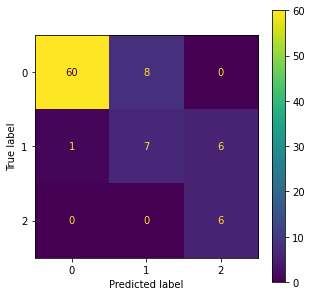

----------------------------------
              precision    recall  f1-score   support

           0       0.98      0.88      0.93        68
           1       0.82      0.53      0.64        68
           2       0.69      1.00      0.81        68

    accuracy                           0.80       204
   macro avg       0.83      0.80      0.80       204
weighted avg       0.83      0.80      0.80       204

----------------------------------


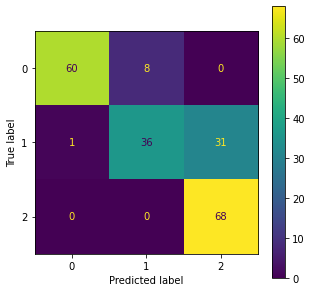

-----------------------------------


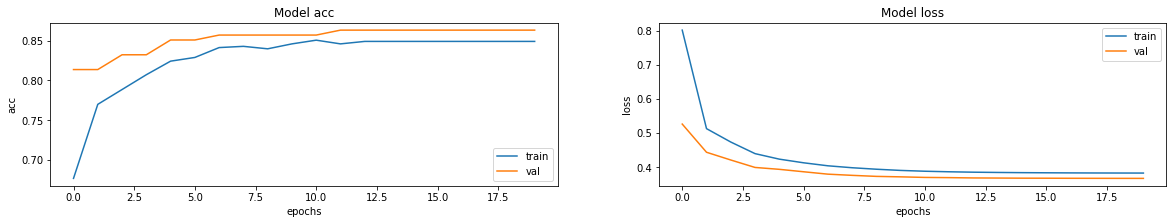

In [29]:
# For first fold
r1 = results[0]
print('Test Loss: ', r1.test_loss)
print('Test Accuracy: ', r1.test_accuracy)
print('----------------------------------')
print(classification_report(r1.y_test, r1.y_pred))
print('----------------------------------')
cm = confusion_matrix(r1.y_test, r1.y_pred)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
print(classification_report(r1.y_test_smote, r1.y_pred_smote))
print('----------------------------------')
cm = confusion_matrix(r1.y_test_smote, r1.y_pred_smote)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('-----------------------------------')
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(r1.model_history[metric])
    ax[i].plot(r1.model_history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

Test Loss:  0.5670297145843506
Test Accuracy:  0.8160919547080994
----------------------------------
              precision    recall  f1-score   support

           0       0.98      0.85      0.91        67
           1       0.48      0.71      0.57        14
           2       0.50      0.67      0.57         6

    accuracy                           0.82        87
   macro avg       0.65      0.74      0.68        87
weighted avg       0.87      0.82      0.83        87

----------------------------------


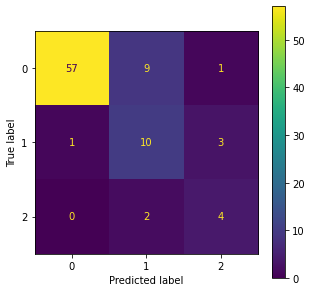

----------------------------------
              precision    recall  f1-score   support

           0       0.97      0.85      0.90        67
           1       0.55      0.70      0.62        67
           2       0.67      0.57      0.61        67

    accuracy                           0.71       201
   macro avg       0.73      0.71      0.71       201
weighted avg       0.73      0.71      0.71       201

----------------------------------


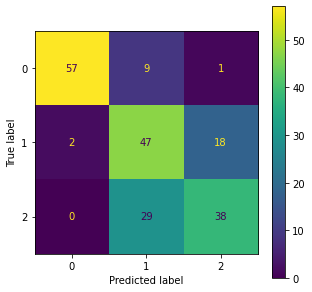

----------------------------------


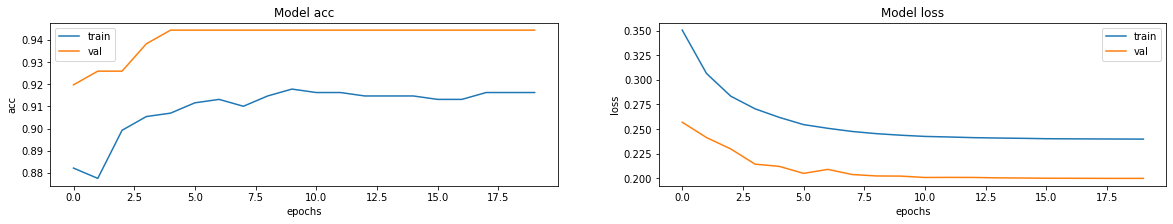

In [30]:
# For second fold
r2 = results[1]
print('Test Loss: ', r2.test_loss)
print('Test Accuracy: ', r2.test_accuracy)
print('----------------------------------')
print(classification_report(r2.y_test, r2.y_pred))
print('----------------------------------')
cm = confusion_matrix(r2.y_test, r2.y_pred)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
print(classification_report(r2.y_test_smote, r2.y_pred_smote))
print('----------------------------------')
cm = confusion_matrix(r2.y_test_smote, r2.y_pred_smote)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(r2.model_history[metric])
    ax[i].plot(r2.model_history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

Test Loss:  0.3427327871322632
Test Accuracy:  0.8505747318267822
----------------------------------
              precision    recall  f1-score   support

           0       0.98      0.85      0.91        67
           1       0.52      0.86      0.65        14
           2       0.83      0.83      0.83         6

    accuracy                           0.85        87
   macro avg       0.78      0.85      0.80        87
weighted avg       0.90      0.85      0.86        87

----------------------------------


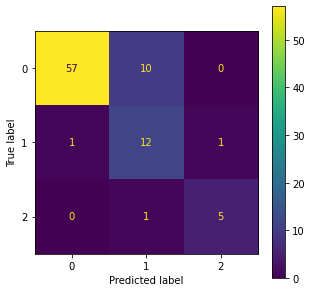

----------------------------------
              precision    recall  f1-score   support

           0       0.90      0.85      0.88        67
           1       0.82      0.82      0.82        67
           2       0.92      0.97      0.94        67

    accuracy                           0.88       201
   macro avg       0.88      0.88      0.88       201
weighted avg       0.88      0.88      0.88       201

----------------------------------


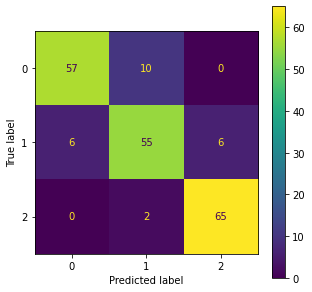

----------------------------------


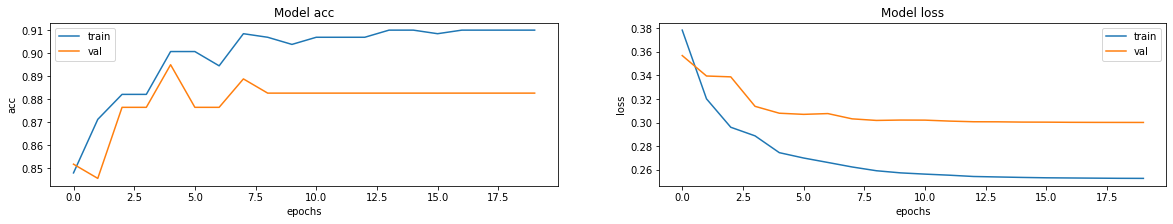

In [31]:
# For third fold
r3 = results[2]
print('Test Loss: ', r3.test_loss)
print('Test Accuracy: ', r3.test_accuracy)
print('----------------------------------')
print(classification_report(r3.y_test, r3.y_pred))
print('----------------------------------')
cm = confusion_matrix(r3.y_test, r3.y_pred)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
print(classification_report(r3.y_test_smote, r3.y_pred_smote))
print('----------------------------------')
cm = confusion_matrix(r3.y_test_smote, r3.y_pred_smote)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(r3.model_history[metric])
    ax[i].plot(r3.model_history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

Test Loss:  0.23451721668243408
Test Accuracy:  0.9080459475517273
----------------------------------
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        67
           1       0.69      0.79      0.73        14
           2       0.83      0.83      0.83         6

    accuracy                           0.91        87
   macro avg       0.83      0.85      0.84        87
weighted avg       0.91      0.91      0.91        87

----------------------------------


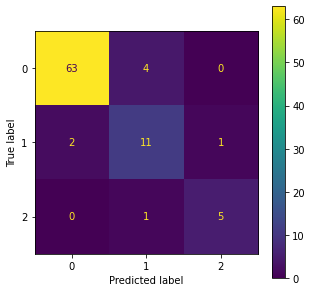

----------------------------------
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        67
           1       0.78      0.75      0.76        67
           2       0.92      0.85      0.88        67

    accuracy                           0.85       201
   macro avg       0.85      0.85      0.84       201
weighted avg       0.85      0.85      0.84       201

----------------------------------


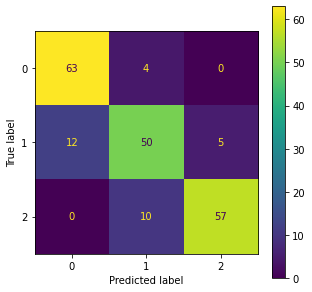

----------------------------------


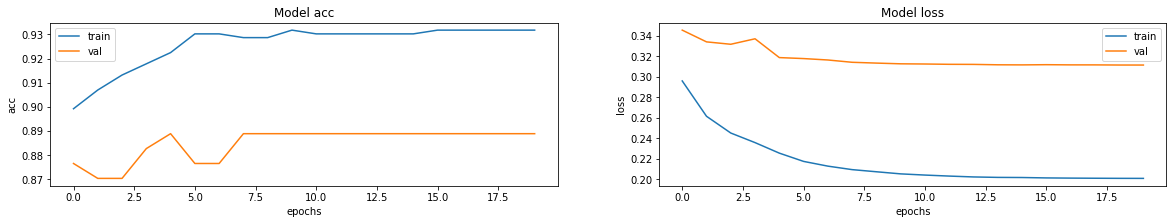

In [32]:
# For fourth fold
r4 = results[3]
print('Test Loss: ', r4.test_loss)
print('Test Accuracy: ', r4.test_accuracy)
print('----------------------------------')
print(classification_report(r4.y_test, r4.y_pred))
print('----------------------------------')
cm = confusion_matrix(r4.y_test, r4.y_pred)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
print(classification_report(r4.y_test_smote, r4.y_pred_smote))
print('----------------------------------')
cm = confusion_matrix(r4.y_test_smote, r4.y_pred_smote)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(r4.model_history[metric])
    ax[i].plot(r4.model_history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

Test Loss:  0.2787352502346039
Test Accuracy:  0.8620689511299133
----------------------------------
              precision    recall  f1-score   support

           0       0.97      0.90      0.93        67
           1       0.55      0.79      0.65        14
           2       0.80      0.67      0.73         6

    accuracy                           0.86        87
   macro avg       0.77      0.78      0.77        87
weighted avg       0.89      0.86      0.87        87

----------------------------------


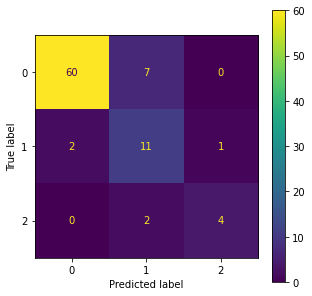

----------------------------------
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        67
           1       0.76      0.75      0.75        67
           2       0.88      0.87      0.87        67

    accuracy                           0.84       201
   macro avg       0.84      0.84      0.84       201
weighted avg       0.84      0.84      0.84       201

----------------------------------


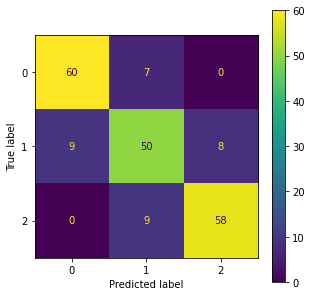

----------------------------------


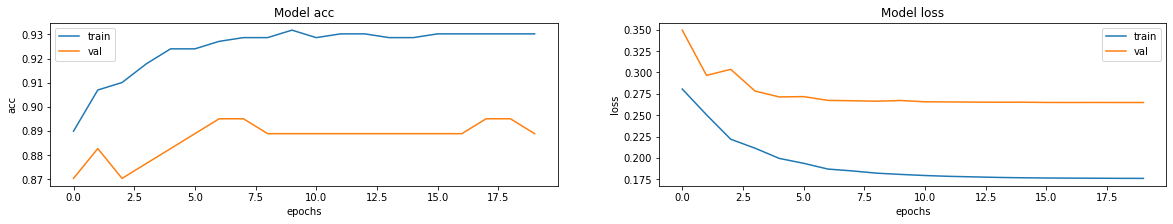

In [33]:
# For fifth fold
r5 = results[4]
print('Test Loss: ', r5.test_loss)
print('Test Accuracy: ', r5.test_accuracy)
print('----------------------------------')
print(classification_report(r5.y_test, r5.y_pred))
print('----------------------------------')
cm = confusion_matrix(r5.y_test, r5.y_pred)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
print(classification_report(r5.y_test_smote, r5.y_pred_smote))
print('----------------------------------')
cm = confusion_matrix(r5.y_test_smote, r5.y_pred_smote)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)
plt.show()
print('----------------------------------')
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(r5.model_history[metric])
    ax[i].plot(r5.model_history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [34]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input_layer (InputLayer)  [(None, 44, 52, 44,  0                                            
__________________________________________________________________________________________________
conv3d_6 (Conv3D)               (None, 44, 52, 44, 6 1792        image_input_layer[0][0]          
__________________________________________________________________________________________________
conv3d_7 (Conv3D)               (None, 44, 52, 44, 6 1792        image_input_layer[0][0]          
__________________________________________________________________________________________________
conv3d_8 (Conv3D)               (None, 44, 52, 44, 6 1792        image_input_layer[0][0]          
____________________________________________________________________________________________

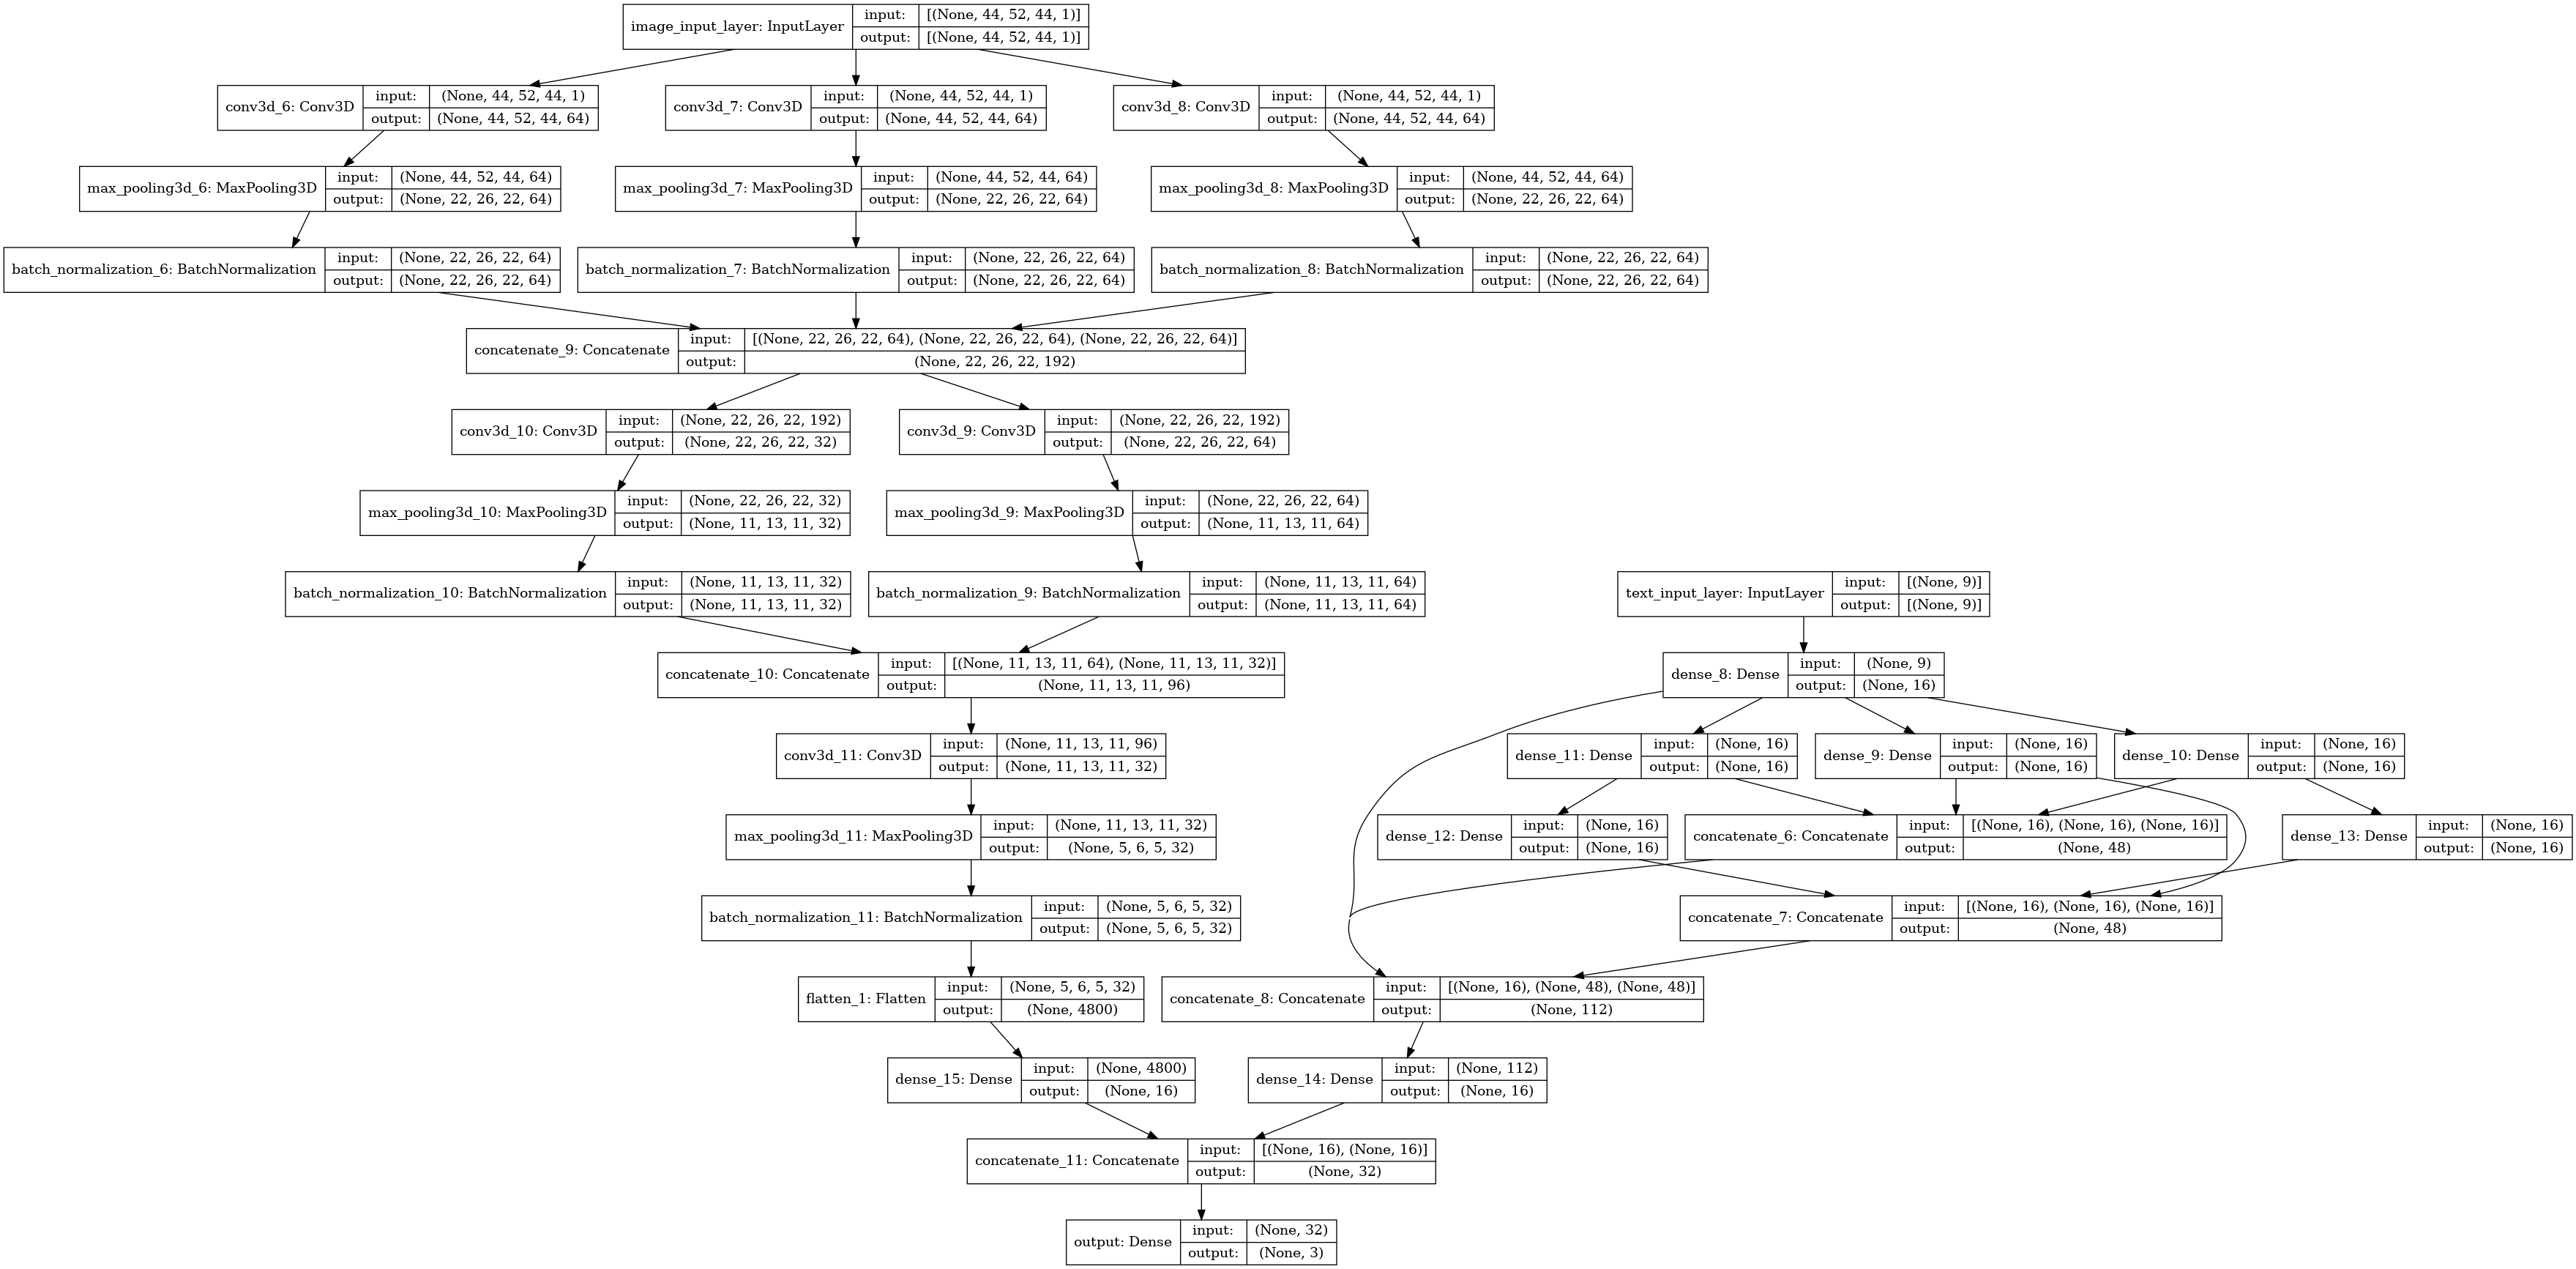

In [35]:
keras.utils.plot_model(model, to_file='multimodal-model.png', show_shapes=True, show_layer_names=True)